# Differentiate weeds from crop seedlings using a convolutional neural network (CNN)

The goal of the project is to correctly identify the weed type from a variety of weed and crop RGB images using a relatively big dataset (~2GB).

Created on Sun Jan 12 12:33:49 2020

@author: neal gilmore

## What is the objective of the machine learning model?

We aim to maximise the accuracy, i.e., the correct classification of the different weed varieties.

## Table of Contents<a id='0.0'></a>

#### [STEP 1: Environment Preparation](#1.0)
1.1 [Import required libraries](#1.1)  
1.2 [Prepare for reproducability](#1.2)  

#### [STEP 2: Data Preparation](#2.0)
2.1 [Import data](#2.1)  
2.2 [Prepare dataframe of image directories and classifications](#2.2)  
2.3 [Summary statistics](#2.3) 

#### [STEP 3: Data Analysis](#3.0)
3.1 [Visualize a few images](#3.1)  

#### [STEP 4: Feature Engineering](#4.0)
4.1 [Separate data into training and test sets](#4.1)  
4.2 [Assess split of classes](#4.2)  
4.3 [Label encode target for multiclass classification](#4.3)  
4.4 [Standardize image sizes](#4.4)  
4.5 [Reshape the dataset](#4.5)  

#### [STEP 5: Model Building](#5.0)
5.1 [Define the convolutional neural network](#5.1)  
5.2 [Complile the model](#5.2)  
5.3 [Train the model](#5.3)  

#### [STEP 6: Model Evaluation](#6.0)
6.1 [Visualize training results](#6.1)  
6.2 [Make a prediction](#6.2)  
6.3 [Create confusion matrix](#6.3)  

## STEP 1: Environment Preparation<a id='1.0'></a> [(Top)](#0.0)

### 1.1 Import required libraries<a id='1.1'></a> [(Top)](#0.0)

In [7]:
# System libraries
import os
import sys
import time
import warnings
from glob import glob

# Basic Python libraries
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set(style="white", color_codes=True)
import missingno as msno # Provides a library of data missingness functions 

# Images library
import cv2

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Tensorflow Keras libraries
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import backend
from keras.utils import np_utils

# ### Turn off Depreciation and Future warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

if not sys.warnoptions:
    warnings.simplefilter('ignore')

#%matplotlib inline

pd.set_option('precision', 3) # set the precision of numerical representation
pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_columns', None) # to display all the columns of the dataframe in the notebook

# Set the plotting style
plt.style.use('default')

print('>> Required libraries imported')

>> Required libraries imported


Using TensorFlow backend.


### 1.2 Prepare for reproducability<a id="1.2"></a>[(Top)](#0.0)

In [8]:
# Set random seed to maintain reproducability
random_state = np.random.seed(42)

## STEP 2: Data Preparation<a id='2.0'></a> [(Top)](#0.0)

### 2.1 Import data<a id='2.1'></a> [(Top)](#0.0)

In [9]:
# Import the dataset

# here are all our images
DATA_FOLDER = '../data/raw/v2-plant-seedlings-dataset'

# each weed class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Cleavers',
 'Sugar beet',
 'Common Chickweed',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Fat Hen',
 'Common wheat',
 'Black-grass',
 'nonsegmentedv2',
 'Small-flowered Cranesbill',
 'Charlock',
 'Maize']

### 2.2 Prepare dataframe of image directories and classifications<a id='2.2'></a> [(Top)](#0.0)

In [10]:
# Walk over the directory structure to understand how 
# the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        print(image_path)

../data/raw/v2-plant-seedlings-dataset/Cleavers/348.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/176.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/88.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/162.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/189.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/77.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/63.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/228.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/200.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/214.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/215.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/201.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/229.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/62.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/188.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/76.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/163.png
../data/raw/v2-plant-seedlings-dataset/Cleavers/177.p

../data/raw/v2-plant-seedlings-dataset/Common Chickweed/343.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/419.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/347.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/421.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/435.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/353.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/409.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/384.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/390.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/623.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/145.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/151.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/637.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/87.png
../data/raw/v2-plant-seedlings-dataset/Common Chickweed/179.png
../data/raw/v2-plant-seedlings-dataset/Co

../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/137.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/651.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/22.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/36.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/686.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/692.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/719.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/731.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/725.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/269.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/255.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/533.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/527.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/241.png
../data/raw/v2-plant-seedlings-dataset/Loose Silky-bent/296.png
../data/raw/v2-plant-seedlings-dataset/Loo

../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/112.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/106.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/489.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/338.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/310.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/476.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/462.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/304.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/474.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/312.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/306.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/460.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/448.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/110.png
../data/raw/v2-plant-seedlings-dataset/Scentless Mayweed/104.png
../data/raw/v2-plant-seed

../data/raw/v2-plant-seedlings-dataset/Fat Hen/239.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/238.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/210.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/204.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/199.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/67.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/73.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/9.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/166.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/98.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/172.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/358.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/402.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/364.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/370.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/416.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/459.png
../data/raw/v2-plant-seedlings-dataset/Fat Hen/317.png
../data/raw/v2-

../data/raw/v2-plant-seedlings-dataset/Common wheat/78.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/186.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/192.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/44.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/2.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/50.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/233.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/227.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/226.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/232.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/3.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/51.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/45.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/193.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/79.png
../data/raw/v2-plant-seedlings-dataset/Common wheat/187.png
../data/raw/v2-plant-seedlings-dataset/Common whea

../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/277.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/288.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/289.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/510.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/276.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/262.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/504.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/538.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/29.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/15.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/100.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/114.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered Cranesbill/128.png
../data/raw/v2-plant-seedlings-dataset/Small-flowered

../data/raw/v2-plant-seedlings-dataset/Charlock/213.png
../data/raw/v2-plant-seedlings-dataset/Charlock/70.png
../data/raw/v2-plant-seedlings-dataset/Charlock/64.png
../data/raw/v2-plant-seedlings-dataset/Charlock/58.png
../data/raw/v2-plant-seedlings-dataset/Charlock/159.png
../data/raw/v2-plant-seedlings-dataset/Charlock/171.png
../data/raw/v2-plant-seedlings-dataset/Charlock/165.png
../data/raw/v2-plant-seedlings-dataset/Charlock/398.png
../data/raw/v2-plant-seedlings-dataset/Charlock/429.png
../data/raw/v2-plant-seedlings-dataset/Charlock/415.png
../data/raw/v2-plant-seedlings-dataset/Charlock/373.png
../data/raw/v2-plant-seedlings-dataset/Charlock/367.png
../data/raw/v2-plant-seedlings-dataset/Charlock/401.png
../data/raw/v2-plant-seedlings-dataset/Charlock/371.png
../data/raw/v2-plant-seedlings-dataset/Charlock/417.png
../data/raw/v2-plant-seedlings-dataset/Charlock/403.png
../data/raw/v2-plant-seedlings-dataset/Charlock/365.png
../data/raw/v2-plant-seedlings-dataset/Charlock/359

In [11]:
# Create a dataframe that stores the paths to the images in one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)
    
    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

image    target
0  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
1  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
2  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
3  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
4  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
5  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
6  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
7  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
8  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers
9  ../data/raw/v2-plant-seedlings-dataset/Cleaver...  Cleavers

### 2.3 Summary statistics<a id='2.3'></a> [(Top)](#0.0)

In [12]:
# Identify how many images per class
images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [13]:
# Isolate a path for demo
# we want to load the image in this path later

images_df.loc[0, 'image']

'../data/raw/v2-plant-seedlings-dataset/Cleavers/348.png'

## STEP 3: Data Analysis<a id='3.0'></a> [(Top)](#0.0)

### 3.1 Visualize a few images<a id='3.1'></a> [(Top)](#0.0)

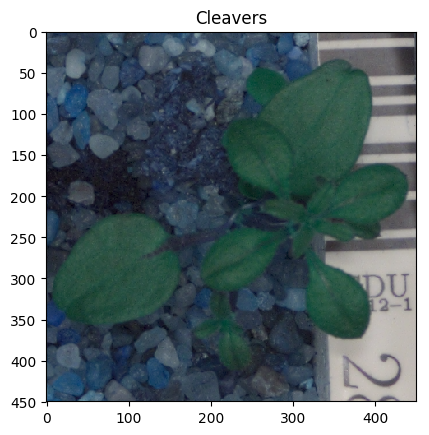

In [14]:
# Visualise a few images
def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)
    
plot_single_image(images_df, 0)

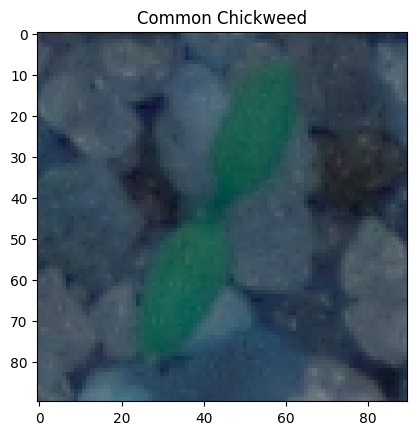

In [15]:
plot_single_image(images_df, 1000)

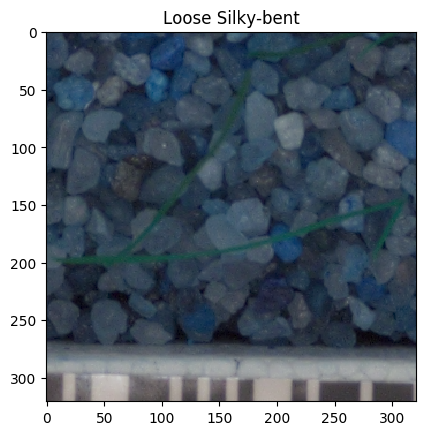

In [16]:
plot_single_image(images_df, 2000)

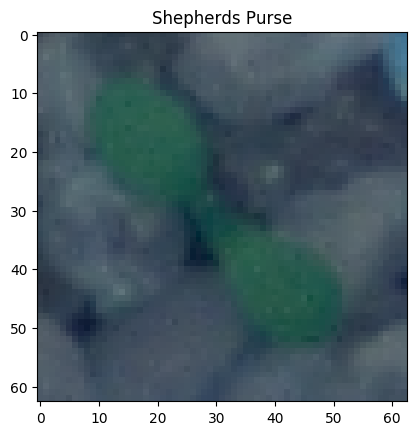

In [17]:
plot_single_image(images_df, 3000)

In [18]:
# Plot a bunch of our images together to get a 
# better feeling of how the images look
def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(16, 16))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1

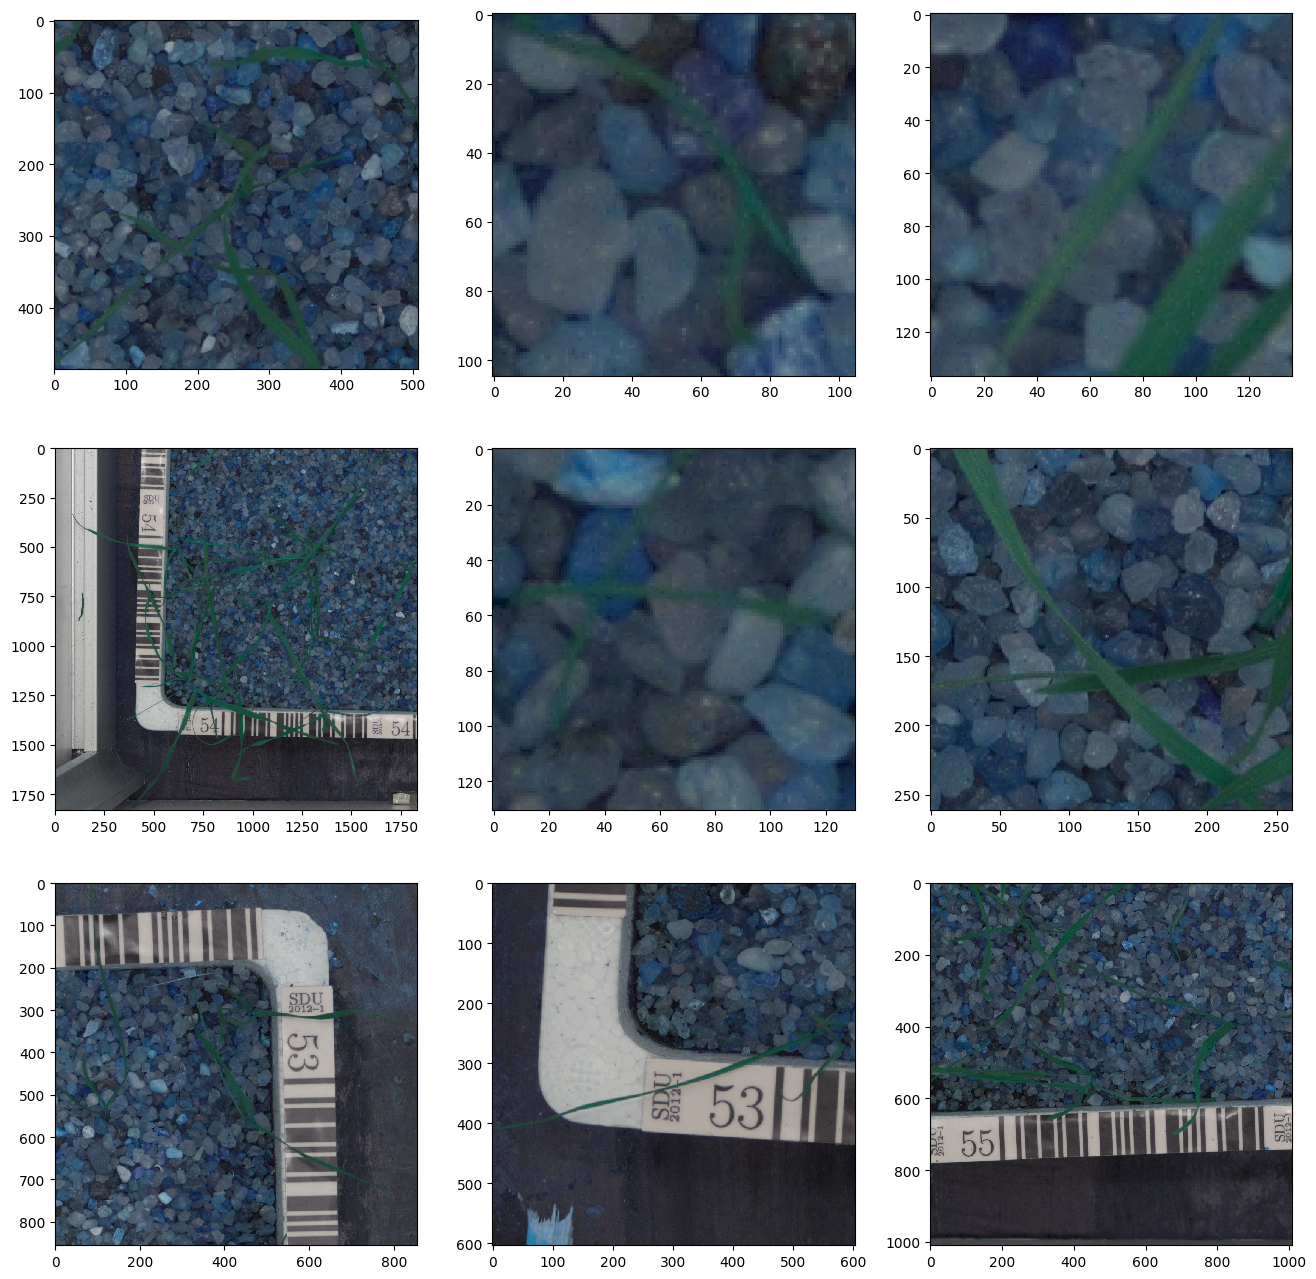

In [19]:
plot_for_class(images_df, 'Loose Silky-bent')

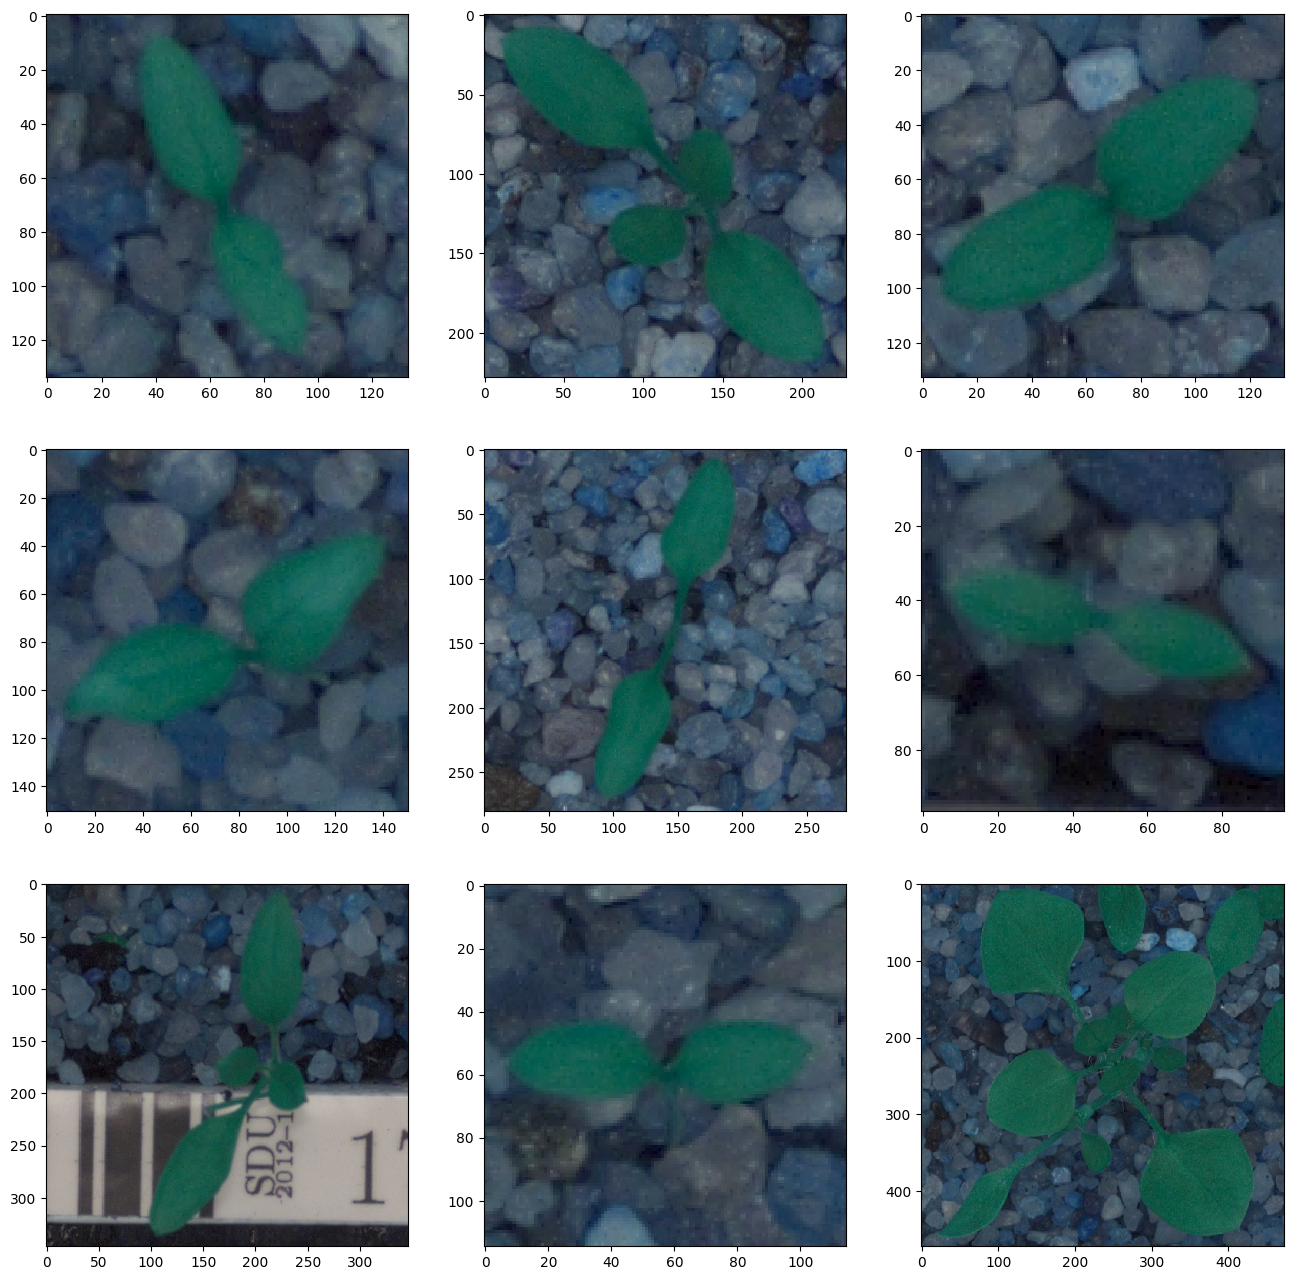

In [20]:
plot_for_class(images_df, 'Common Chickweed')

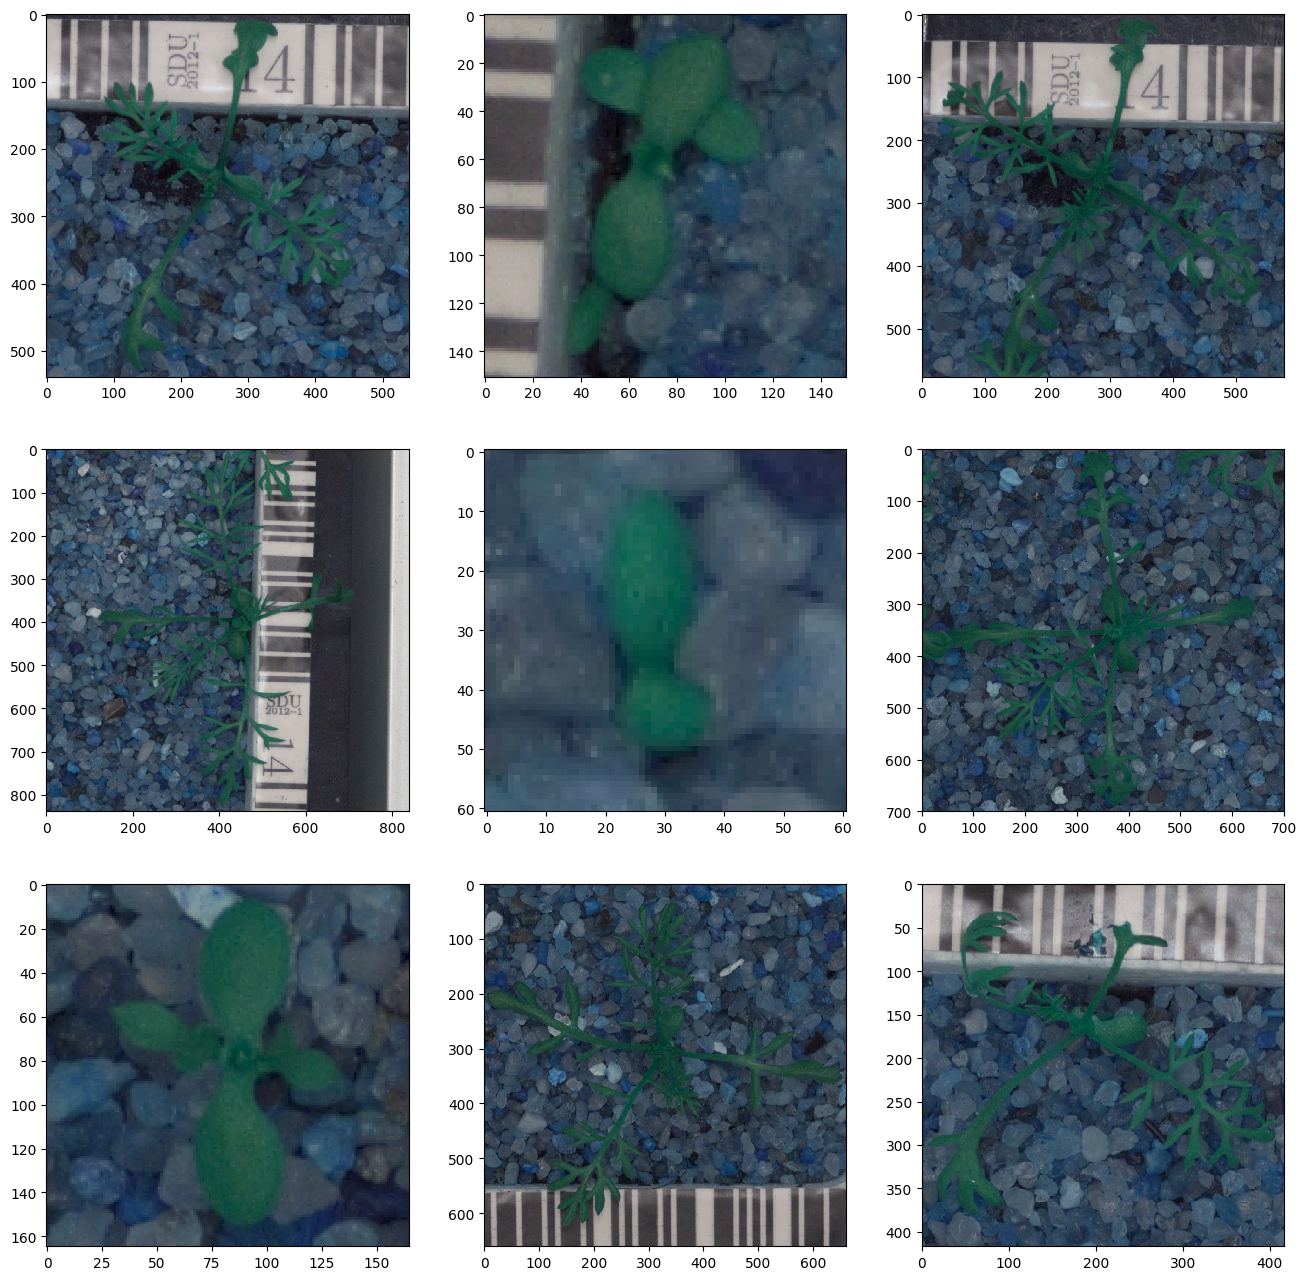

In [21]:
plot_for_class(images_df, 'Scentless Mayweed')

## STEP 4: Feature Engineering<a id='4.0'></a> [(Top)](#0.0)

### 4.1 Separate data into training and test sets<a id='4.1'></a> [(Top)](#0.0)

In [22]:
# Separate the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images_df['image'], 
                                                    images_df['target'], 
                                                    test_size=0.20, 
                                                    random_state=random_state)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [23]:
# Reset the index as later we iterate over the data by rownumber
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train.head()

0    ../data/raw/v2-plant-seedlings-dataset/Small-f...
1    ../data/raw/v2-plant-seedlings-dataset/Scentle...
2    ../data/raw/v2-plant-seedlings-dataset/Scentle...
3    ../data/raw/v2-plant-seedlings-dataset/Charloc...
4    ../data/raw/v2-plant-seedlings-dataset/Common ...
Name: image, dtype: object

In [24]:
# Likewise, reset index of the target
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 4.2 Assess split of classes<a id='4.2'></a> [(Top)](#0.0)

In [25]:
# Assess percentage of images within each class
y_train.value_counts() / len(y_train)

Loose Silky-bent             0.139
Common Chickweed             0.130
Scentless Mayweed            0.110
Small-flowered Cranesbill    0.103
Fat Hen                      0.100
Sugar beet                   0.082
Charlock                     0.080
Cleavers                     0.058
Black-grass                  0.056
Shepherds Purse              0.051
Common wheat                 0.047
Maize                        0.045
Name: target, dtype: float64

In [26]:
# Should be the same in the test set
y_test.value_counts() / len(y_test)

Loose Silky-bent             0.131
Common Chickweed             0.125
Scentless Mayweed            0.109
Small-flowered Cranesbill    0.106
Sugar beet                   0.090
Charlock                     0.089
Fat Hen                      0.087
Cleavers                     0.071
Black-grass                  0.053
Maize                        0.053
Shepherds Purse              0.042
Common wheat                 0.042
Name: target, dtype: float64

### 4.3 Label encode target for multiclass classification<a id='4.3'></a> [(Top)](#0.0)

In [27]:
# Label encode target for multiclass classification
encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 4.4 Standardize image sizes<a id='4.4'></a> [(Top)](#0.0)

In [28]:
# The source images are all different sizes
# For neural networks however, we need images in the same size
# Therefore, we will standardize image sizes
IMAGE_SIZE = 150

def im_resize(df, n):
    im = cv2.imread(df[n])
    im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
    return im

In [29]:
tmp = im_resize(X_train, 7)
tmp.shape

(150, 150, 3)

### 4.5 Reshape the dataset<a id='4.5'></a> [(Top)](#0.0)

In [30]:
# The shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations,
# n2 and n3 are image width and length
# and n4 indicates that it is a color image
# with 3 planes per image (RGB)
def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    tmp = np.zeros((len(df), image_size, image_size, 3), dtype='float32')

    for n in range(0, len(df)):
        im = im_resize(df, n)
        tmp[n] = im
  
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [31]:
# Reshape the training dataset
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 150, 150, 3) size: 299,092,500


In [32]:
# Reshape the test dataset
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 150, 150, 3) size: 74,790,000


In [33]:
# number of different classes
print('Number of different classes:', len(y_train.unique()))

Number of different classes: 12


## STEP 5: Model Building<a id='5.0'></a> [(Top)](#0.0)

### 5.1 Define the convolutional neural network<a id='5.1'></a> [(Top)](#0.0)

In [34]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
#model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
#model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0

### 5.2 Compile the model<a id='5.2'></a> [(Top)](#0.0)

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

### 5.3 Train the model<a id='5.3'></a> [(Top)](#0.0)

In [36]:
# Set model parameters
batch_size = 10
epochs = 8

In [38]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=1, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(x=x_train, 
                    y=train_y,
                    batch_size=batch_size, 
                    validation_split=10,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)

Train on 4431 samples
Epoch 1/8

Epoch 00001: accuracy improved from -inf to 0.94335, saving model to model.h5
4431/4431 - 152s - loss: 0.1499 - accuracy: 0.9434
Epoch 2/8

Epoch 00002: accuracy improved from 0.94335 to 0.95370, saving model to model.h5
4431/4431 - 149s - loss: 0.1224 - accuracy: 0.9537
Epoch 3/8

Epoch 00003: accuracy improved from 0.95370 to 0.96135, saving model to model.h5
4431/4431 - 151s - loss: 0.1026 - accuracy: 0.9614
Epoch 4/8

Epoch 00004: accuracy improved from 0.96135 to 0.96797, saving model to model.h5
4431/4431 - 145s - loss: 0.0841 - accuracy: 0.9680
Epoch 5/8

Epoch 00005: accuracy improved from 0.96797 to 0.97322, saving model to model.h5
4431/4431 - 151s - loss: 0.0683 - accuracy: 0.9732
Epoch 6/8

Epoch 00006: accuracy improved from 0.97322 to 0.97867, saving model to model.h5
4431/4431 - 156s - loss: 0.0567 - accuracy: 0.9787
Epoch 7/8

Epoch 00007: accuracy improved from 0.97867 to 0.98366, saving model to model.h5
4431/4431 - 151s - loss: 0.0446

## STEP 6: Model Evaluation<a id='6.0'></a> [(Top)](#0.0)

### 6.1 Visualize training results<a id='6.1'></a> [(Top)](#0.0)

<Figure size 640x480 with 0 Axes>

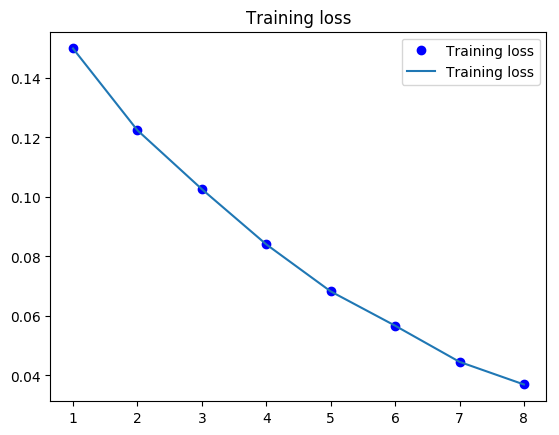

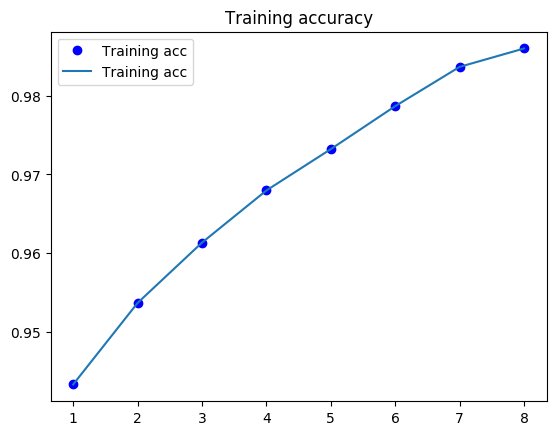

<Figure size 640x480 with 0 Axes>

In [42]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, acc, label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

### 6.2 Make a prediction<a id='6.2'></a> [(Top)](#0.0)

In [43]:
# Make a prediction
predictions = model.predict_classes(x_test, verbose=1)

1108/1108 [==============================] - 10s 9ms/sample


In [44]:
# Inspect predictions
predictions

array([ 0, 11, 10, ...,  3,  5,  2])

In [45]:
# Transform target
encoder.transform(y_test)

array([ 0,  8, 10, ...,  3,  5,  2])

### 6.3 Create confusion matrix<a id='6.3'></a> [(Top)](#0.0)

In [46]:
# Create confusion matrix
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)